In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import PillowWriter

## Load evolution data

In [2]:
bbox_path = "data/8.477_47.336_8.605_47.417"
df = pd.read_csv(bbox_path + "/evolution.csv")
df["time_stamp"] = df["time_stamp"].str[:10]
df["time_stamp"] = pd.to_datetime(df["time_stamp"], format="%Y-%m-%d")
df["time_stamp"] = df["time_stamp"].dt.to_period("M").dt.to_timestamp()
df = df.sort_values("time_stamp")
df = df.set_index("time_stamp")
df.head()

,cloud_coverage_api,cloud_coverage_calculated,buildup_pct,green_pct,water_pct,empty_pct
time_stamp,,,,,,
2017-02-01,2.36,0.0,35.187602,45.534013,6.044872,13.233514
2017-03-01,2.21,0.0,40.208385,46.903108,5.811376,7.077131
2017-03-01,0.94,0.0,32.384852,48.218577,5.502734,13.893837
2017-04-01,2.20,0.0,36.357150,53.021285,5.970531,4.651034
2017-04-01,2.52,0.0,32.313618,57.668407,6.037276,3.980699


## Data Count Histogram

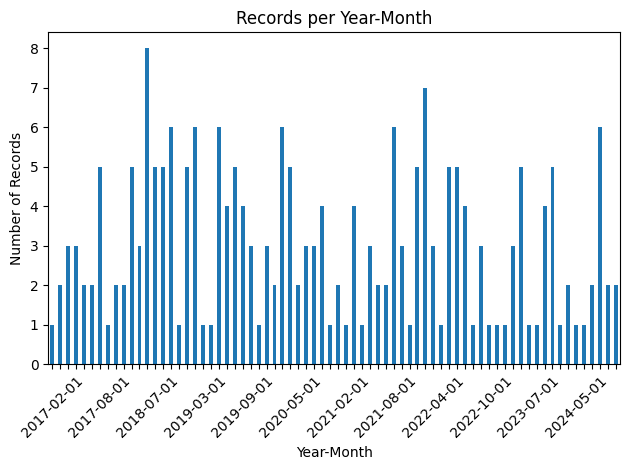

In [3]:
# Count records per year-month
counts = df.index.value_counts().sort_index()

# Plot
ax = counts.plot(kind="bar")
plt.xlabel("Year-Month")
plt.ylabel("Number of Records")
plt.title("Records per Year-Month")

# Show only every 6th label
labels = [str(label)[:10] if i % 6 == 0 else "" for i, label in enumerate(counts.index)]
ax.set_xticklabels(labels, rotation=45)

plt.tight_layout()
plt.show()

## Normalise values (drop empty pixels from count)

In [4]:
df_norm = df.drop(columns=["empty_pct"])
row_sums = df_norm[["cloud_coverage_calculated", "buildup_pct", "green_pct", "water_pct"]].sum(axis=1)

# Divide each value by the row sum and multiply by 100 to normalize
df_norm[["cloud_coverage_calculated", "buildup_pct", "green_pct", "water_pct"]] = (
    df_norm[["cloud_coverage_calculated", "buildup_pct", "green_pct", "water_pct"]]
    .div(row_sums, axis=0)
    .mul(100)
)
df_norm.head()

,cloud_coverage_api,cloud_coverage_calculated,buildup_pct,green_pct,water_pct
time_stamp,,,,,
2017-02-01,2.36,0.0,40.554370,52.478802,6.966828
2017-03-01,2.21,0.0,43.270710,50.475312,6.253978
2017-03-01,0.94,0.0,37.610376,55.998984,6.390639
2017-04-01,2.20,0.0,38.130618,55.607614,6.261768
2017-04-01,2.52,0.0,33.653253,60.059182,6.287565


## Plot evolution of areas

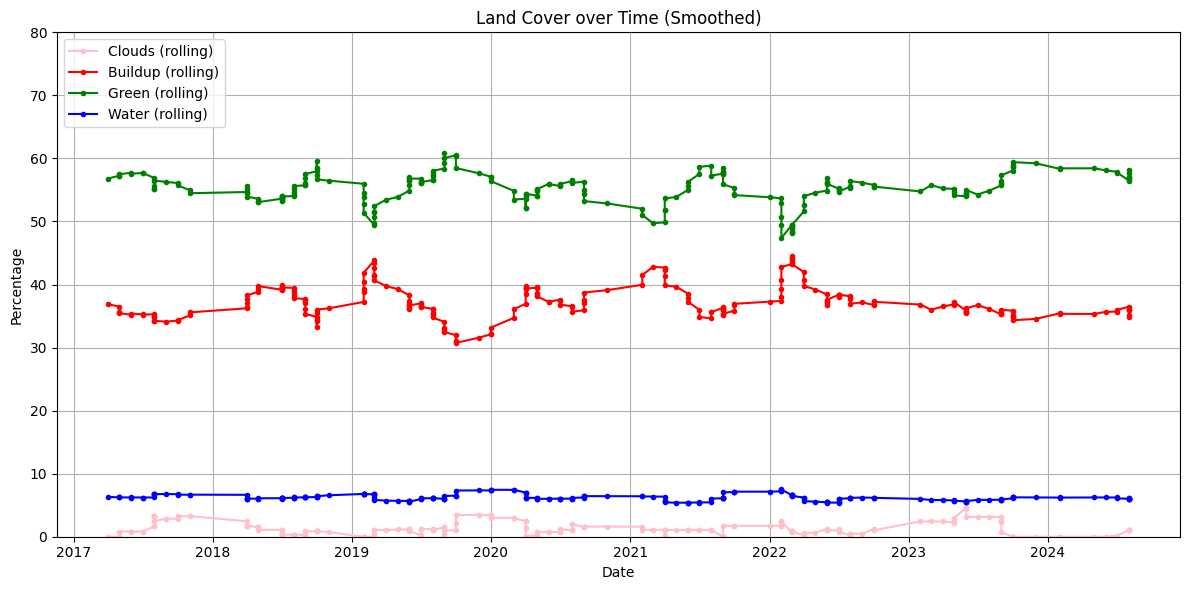

In [5]:
rolling_average = True

if rolling_average:
    window_size = 10
    df2 = df_norm.rolling(window=window_size, center=True).mean()
else:
    df2 = df_norm

marker = "o"
markersize = 3

plt.figure(figsize=(12, 6))
plt.plot(df.index, df2["cloud_coverage_calculated"], label="Clouds (rolling)", color="pink", marker=marker, markersize=markersize)
plt.plot(df.index, df2["buildup_pct"], label="Buildup (rolling)", color="red", marker=marker, markersize=markersize)
plt.plot(df.index, df2["green_pct"], label="Green (rolling)", color="green", marker=marker, markersize=markersize)
plt.plot(df.index, df2["water_pct"], label="Water (rolling)", color="blue", marker=marker, markersize=markersize)

plt.xlabel("Date")
plt.ylabel("Percentage")
plt.title("Land Cover over Time (Smoothed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper left")
plt.ylim(0, 80)
plt.show()

## Save as gif

GIF saved as 'animation.gif'


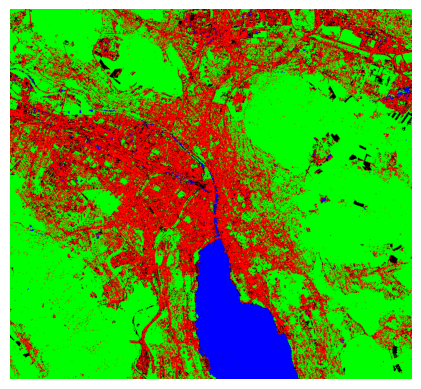

In [6]:
# load all numpy arrays from the dir
npy_files = [f for f in os.listdir(bbox_path) if f.endswith(".npy")]
npy_arrays = [np.load(os.path.join(bbox_path, f)) for f in npy_files]

fig, ax = plt.subplots()

# PillowWriter for gif output
writer = PillowWriter(fps=20)  # Adjust fps as needed

# create gif animation
with writer.saving(fig, "animation.gif", dpi=100):
    for array in npy_arrays:
        ax.clear()  # clear previous frame
        ax.imshow(array, cmap='gray')
        ax.set_axis_off()
        writer.grab_frame()

print("GIF saved as 'animation.gif'")